In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Thu Apr 30 10:55:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    40W / 250W |   7715MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [15]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [0]:
%matplotlib inline
import os
import numpy as np
import keras
import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path_train_im='/content/drive/My Drive/Colab Notebooks/dataset/aerial/train_tiles/tile_im/'
path_train_gt='/content/drive/My Drive/Colab Notebooks/dataset/aerial/train_tiles/tile_gt/'

path_val_im='/content/drive/My Drive/Colab Notebooks/dataset/aerial/val_tiles/tile_im/'
path_val_gt='/content/drive/My Drive/Colab Notebooks/dataset/aerial/val_tiles/tile_gt/'

[  0 255]
(384, 384)


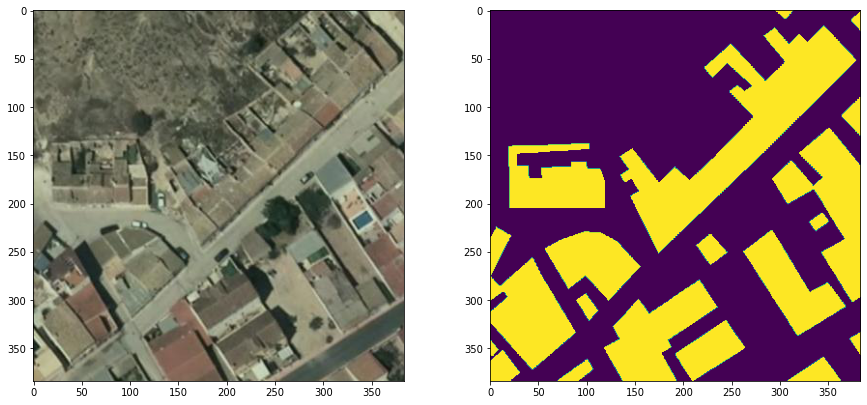

In [19]:
mascara=Image.open(path_train_gt+'tile_gt/681051.12_4238267.56_681147.12_4238363.56.png')
mascara=np.array(mascara)

foto=Image.open(path_train_im+'tile_im/681051.12_4238267.56_681147.12_4238363.56.jpg')

print(np.unique(mascara))

print(mascara.shape)

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(foto)


plt.subplot(222)
plt.imshow(mascara)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

seed=164

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

img_train= image_datagen.flow_from_directory(
    path_train_im,
    target_size=(384,384,),
    batch_size=2,
    class_mode=None,
    seed=seed)

mask_train = mask_datagen.flow_from_directory(
    path_train_gt,
    target_size=(384,384),
    batch_size=2,
    class_mode=None,
    color_mode='grayscale',
    seed=seed
)

train_gen=zip(img_train,mask_train)

Found 3200 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.


In [21]:
val_image_datagen=ImageDataGenerator(rescale=1./255)
val_mask_datagen=ImageDataGenerator(rescale=1./255)

img_val = val_image_datagen.flow_from_directory(
path_val_im,
target_size=(384,384,),
class_mode=None,
shuffle=False
)

mask_val = mask_datagen.flow_from_directory(
path_val_gt,
target_size=(384,384,),
class_mode=None,
color_mode='grayscale',
shuffle=False
)

val_gen=zip(img_train,mask_train)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


In [22]:
!pip install segmentation-models==1.0.0

# Unet Resnet34 - binary_crossentropy

In [0]:
from segmentation_models import Linknet
#from segmentation_models.metrics import iou_score
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss

In [0]:
model_unet_1=Linknet(
    backbone_name='vgg19',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet')

In [0]:
metric = IOUScore()
loss=JaccardLoss()
model_unet_1.compile(
    'Adam',
    loss='binary_crossentropy',
    #loss=loss,
    metrics=['accuracy',metric])
    #metrics=['accuracy',iou_score])
#model_unet_1.summary()

In [26]:
hist_unet_1=model_unet_1.fit_generator(
    train_gen,
    steps_per_epoch=1600,
    epochs=200,
    validation_data=val_gen,
    validation_steps=400)

Epoch 1/200
1600/1600 [==============================] - 225s 140ms/step - loss: 0.3584 - accuracy: 0.8598 - iou_score: 0.2044 - val_loss: 0.3336 - val_accuracy: 0.8640 - val_iou_score: 0.1943
Epoch 2/200
1600/1600 [==============================] - 221s 138ms/step - loss: 0.3224 - accuracy: 0.8736 - iou_score: 0.2527 - val_loss: 0.9382 - val_accuracy: 0.4474 - val_iou_score: 0.1932
Epoch 3/200
1600/1600 [==============================] - 220s 138ms/step - loss: 0.2882 - accuracy: 0.8863 - iou_score: 0.3080 - val_loss: 0.2601 - val_accuracy: 0.9010 - val_iou_score: 0.3177
Epoch 4/200
1600/1600 [==============================] - 221s 138ms/step - loss: 0.2551 - accuracy: 0.8992 - iou_score: 0.3423 - val_loss: 0.2220 - val_accuracy: 0.8789 - val_iou_score: 0.3083
Epoch 5/200
1600/1600 [==============================] - 220s 138ms/step - loss: 0.2332 - accuracy: 0.9083 - iou_score: 0.3827 - val_loss: 0.0409 - val_accuracy: 0.9124 - val_iou_score: 0.4035
Epoch 6/200
1600/1600 [============

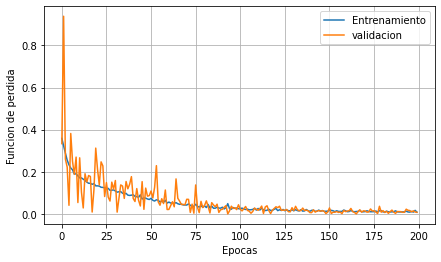

In [27]:
plt.figure(figsize=(7,4))
plt.plot(hist_unet_1.history['loss'])
plt.plot(hist_unet_1.history['val_loss'])
plt.xlabel('Epocas')
plt.ylabel('Funcion de perdida')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

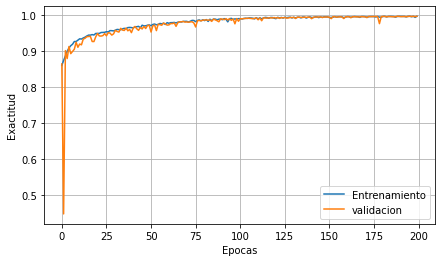

In [28]:
plt.figure(figsize=(7,4))
plt.plot(hist_unet_1.history['accuracy'])
plt.plot(hist_unet_1.history['val_accuracy'])
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

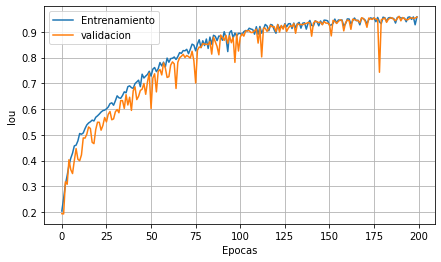

In [29]:
plt.figure(figsize=(7,4))
plt.plot(hist_unet_1.history['iou_score'])
plt.plot(hist_unet_1.history['val_iou_score'])
plt.xlabel('Epocas')
plt.ylabel('Iou')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

In [0]:
#modelo_epoch_batchsize
model_unet_1.save('/content/drive/My Drive/Colab Notebooks/vgg19_2_200.h5')

In [0]:
x_val_unet1=[]
y_val_unet1=[]

for i in range(len(img_val)):
    y_val_unet1.extend(mask_val[i])
    x_val_unet1.extend(img_val[i])

In [0]:
prob_val_unet1=model_unet_1.predict_generator(img_val)

In [0]:
y_pred_val_unet1 = np.zeros(prob_val_unet1.shape)
y_pred_val_unet1[prob_val_unet1>0.5]=255

In [34]:
#Evalucion

val_loss,val_acc,val_iou=model_unet_1.evaluate_generator(
    val_gen,
    steps=int(len(img_val)/2)
)

print('Exactitud: ',format(100*val_acc,'.2f'),'%')
print('IoU: ',format(100*val_iou,'.2f'),'%')

Exactitud:  99.54 %
IoU:  96.03 %


In [0]:
## 50 epoch 2 batch
## 97.71 y 79.61
## 50 epoch 2 batch
##

Text(0.5, 1.0, 'Mascara predicha')

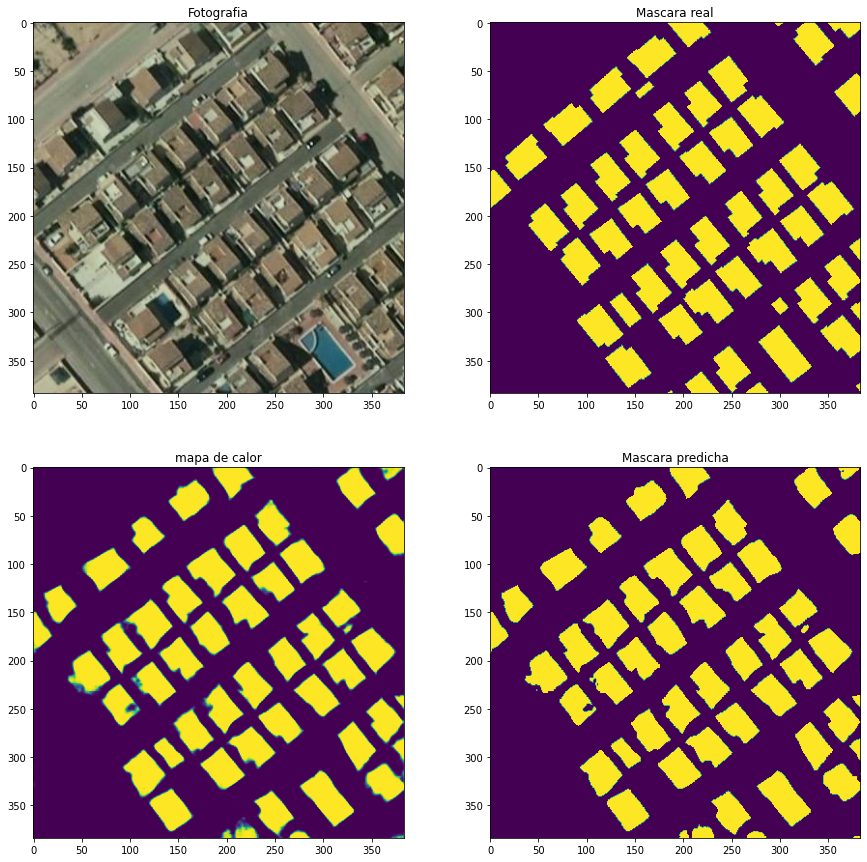

In [36]:
ind=233

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet1[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet1[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet1[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet1[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

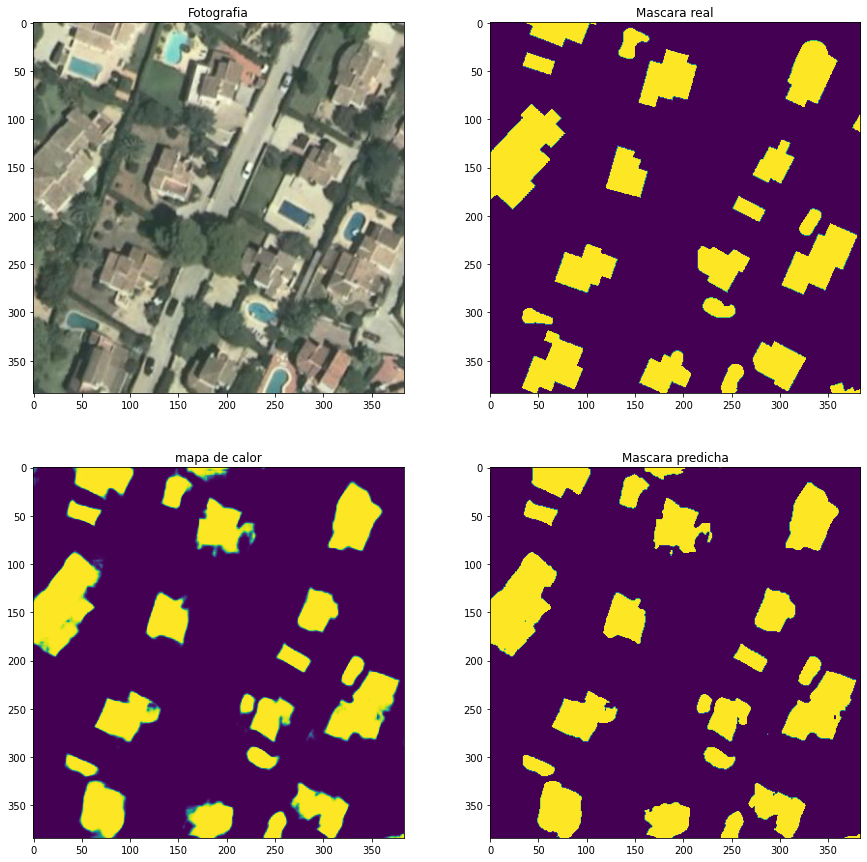

In [37]:
ind=799

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet1[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet1[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet1[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet1[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

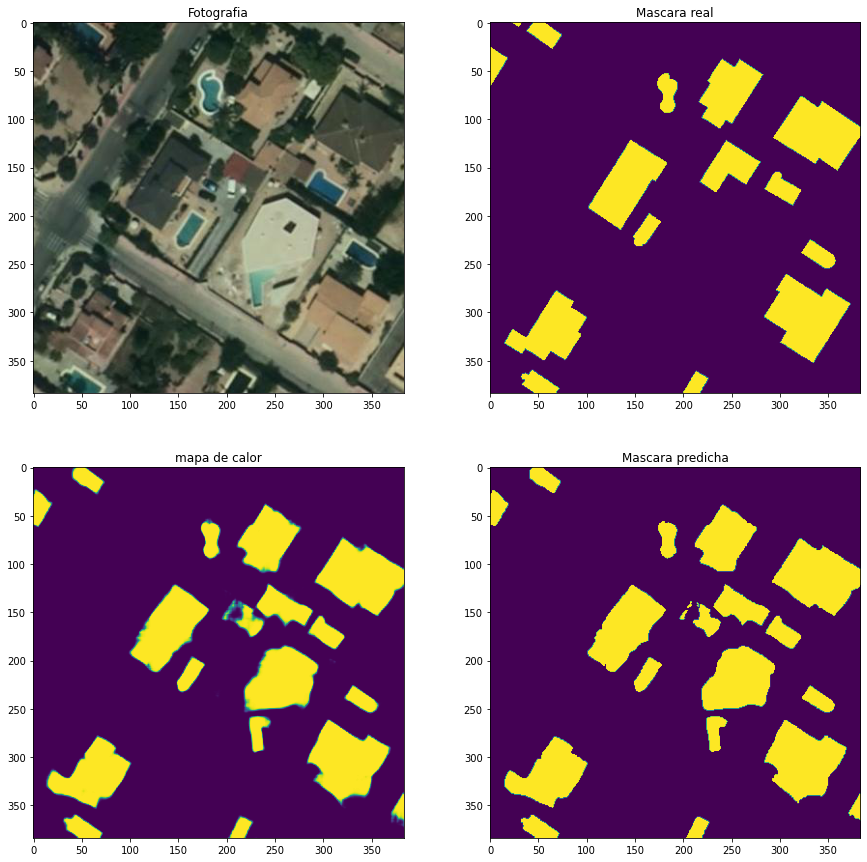

In [38]:
ind=500

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet1[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet1[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet1[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet1[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

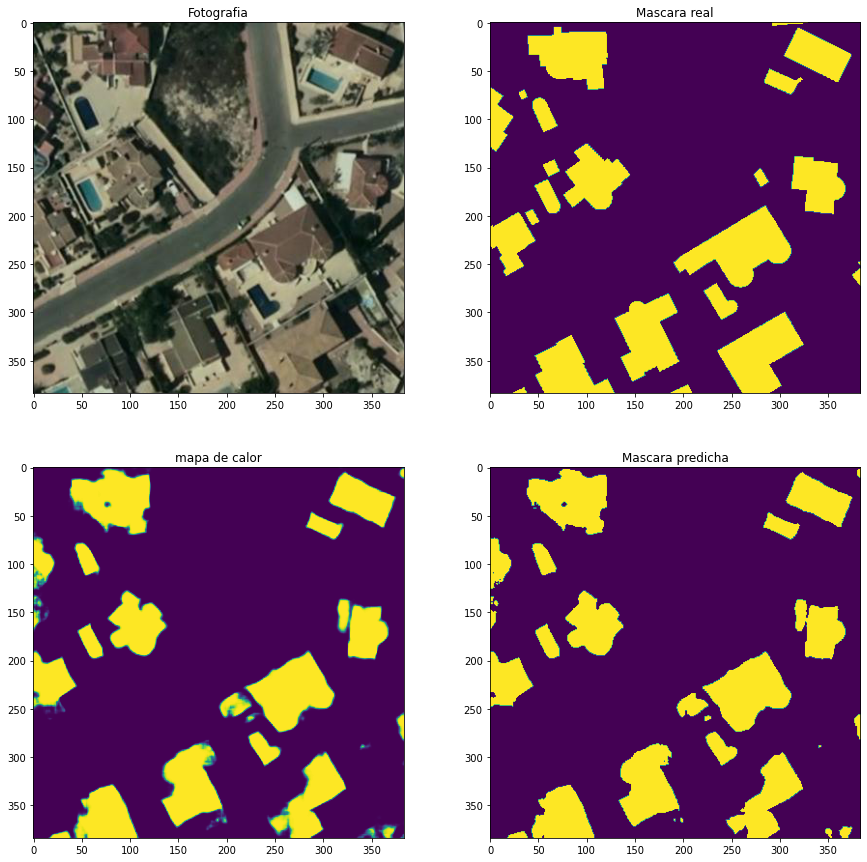

In [39]:
ind=201

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet1[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet1[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet1[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet1[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

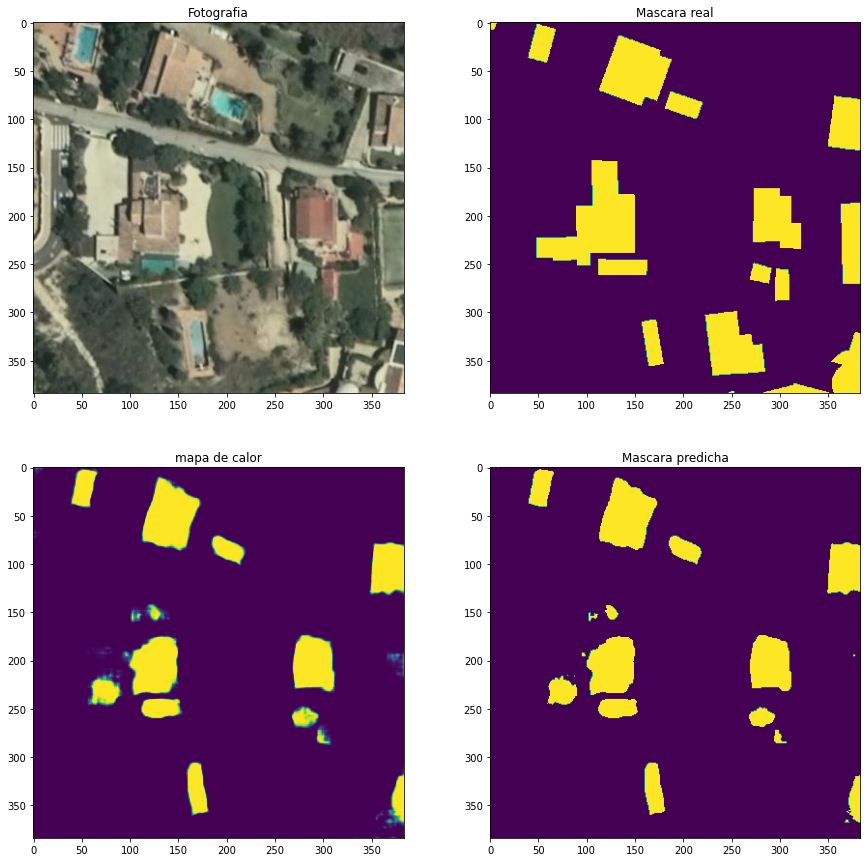

In [40]:
ind=775

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet1[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet1[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet1[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet1[ind,:,:,0])
plt.title('Mascara predicha')

In [0]:
#from keras.models import load_model
#model = load_model('prueba_iou.h5',custom_objects={'iou_score': IOUScore()})
#model.summary()

In [42]:
keras.__version__

'2.3.1'

In [43]:
tf.__version__

'2.2.0-rc3'

In [0]:
#ijacarloss_batch4_10epochs_400_100_ha ido bastante bien

In [0]:
#binary_batch2_100epochs_400_100_ha ido bastante bien